Kaggle Dataset
https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data?select=spreadspoke_scores.csv

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


Spread covered distribution:
spread_covered
1    0.570004
0    0.429996
Name: proportion, dtype: float64

Over hit distribution:
over_hit
0    0.517555
1    0.482445
Name: proportion, dtype: float64


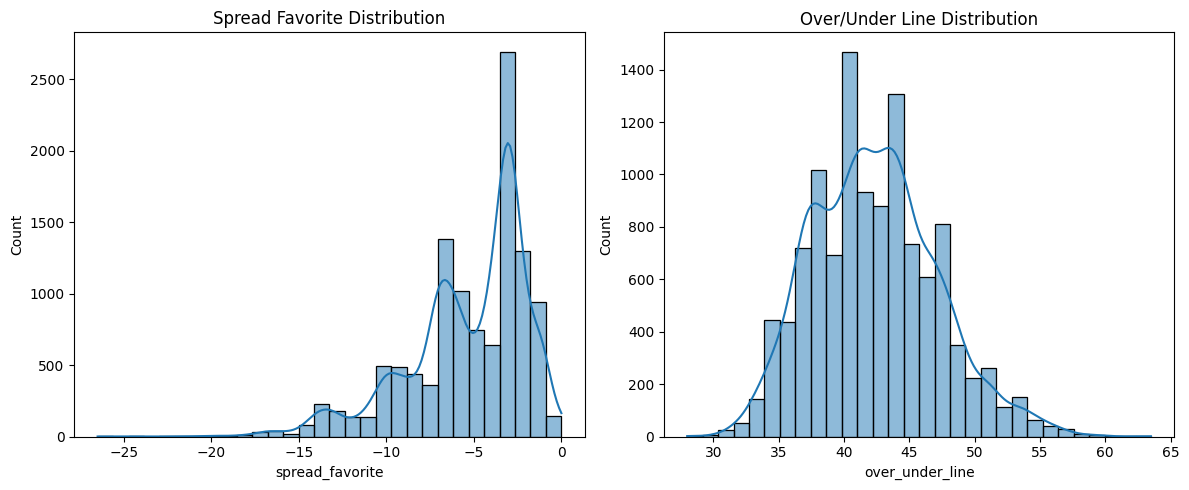


Final dataset saved as 'processed_spreadspoke_scores.csv'
Number of rows in final dataset: 11535


In [2]:
# Load dataset
df = pd.read_csv('spreadspoke_scores.csv')

# Create target labels
# Total score
df['total_score'] = df['score_home'] + df['score_away']

# Binary: Did the favorite team win?
df['fav_won'] = (
    (df['team_favorite_id'] == df['team_home']) & (df['score_home'] > df['score_away']) |
    (df['team_favorite_id'] == df['team_away']) & (df['score_away'] > df['score_home'])
).astype(int)

# Binary: Did the game go over the betting line?
df['over_hit'] = (df['total_score'] > pd.to_numeric(df['over_under_line'], errors='coerce')).astype(int)

# Calculate margin of victory
df['score_margin'] = df['score_home'] - df['score_away']
df['spread_favorite'] = pd.to_numeric(df['spread_favorite'], errors='coerce')
df['favorite_is_home'] = df['team_favorite_id'] == df['team_home']

# Binary: Did the favorite cover the spread?
df['spread_covered'] = (
    (df['favorite_is_home'] & (df['score_margin'] > df['spread_favorite'])) |
    (~df['favorite_is_home'] & (-df['score_margin'] > df['spread_favorite']))
).astype(int)

# Select relevant columns
columns_to_keep = [
    'team_home', 'team_away', 'team_favorite_id',
    'spread_favorite', 'over_under_line',
    'fav_won', 'over_hit', 'spread_covered', 'total_score'
]
model_df = df[columns_to_keep].copy()

# Drop rows with missing values in important fields
model_df['spread_favorite'] = pd.to_numeric(model_df['spread_favorite'], errors='coerce')
model_df['over_under_line'] = pd.to_numeric(model_df['over_under_line'], errors='coerce')
model_df = model_df.dropna(subset=['spread_favorite', 'over_under_line'])

# One-hot encode categorical fields
model_df_encoded = pd.get_dummies(model_df, columns=['team_home', 'team_away', 'team_favorite_id'])

# Normalize numeric features
features_to_normalize = ['spread_favorite', 'over_under_line']
scaler = MinMaxScaler()
model_df_encoded[features_to_normalize] = scaler.fit_transform(model_df_encoded[features_to_normalize])

# Show class distribution
print("Spread covered distribution:")
print(model_df_encoded['spread_covered'].value_counts(normalize=True))
print("\nOver hit distribution:")
print(model_df_encoded['over_hit'].value_counts(normalize=True))

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(model_df['spread_favorite'], bins=30, kde=True)
plt.title('Spread Favorite Distribution')

plt.subplot(1, 2, 2)
sns.histplot(model_df['over_under_line'], bins=30, kde=True)
plt.title('Over/Under Line Distribution')

plt.tight_layout()
plt.show()

# Save processed dataset
model_df_encoded.to_csv('processed_spreadspoke_scores.csv', index=False)
print("\nFinal dataset saved as 'processed_spreadspoke_scores.csv'")
print("Number of rows in final dataset:", model_df_encoded.shape[0])
